# Trying to use transfer learning for different numbers of agents, and compare performances

In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

from importlib import reload
import utils
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)

<module 'utils.train_test_methods' from '/Users/zz/Documents/GT20F/7000/GNN_experiments/utils/train_test_methods.py'>

In [4]:
U_VELOCITY = 1
U_ACCELERATION = 2
O_VELOCITY = 1
O_ACCELERATION = 2

# Use the purple-pink pair (LA-uVel-oVel & RA-uVel-oVel) as example
input_type = U_VELOCITY
observe_type = O_VELOCITY

# Let's start with a larger environment to test out transfer learning
N = 100
env_ms = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped
N = 10
env = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped


In [15]:
# Load pre-trained models
agent5 = LearnerAgent(device, N, env.no, env.na, hidden)
agent7 = RewardAgent(device, N, env.no, env.na, hidden)
agent5.load_model('models/LearnerAgent_test3_LA-uVel-oVel')
agent7.load_model('models/RewardAgent_test3_RA-uVel-oVel')

Loading model from models/LearnerAgent_test3_LA-uVel-oVel
Loading model from models/RewardAgent_test3_RA-uVel-oVel


In [82]:
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from train_test_methods import *


In [8]:
na = env.na
ns = env.nf
hidden = 32

num_episode=500
transfer_num_episode=101
test_interval=50
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

if input_type == U_ACCELERATION:
    action_space = [-env.a_max, env.a_max]
else:
    action_space = [-env.v_max, env.v_max]


In [9]:
# Train the base network (100 agents)
N = 100
seed=202020

LA100_ms = LearnerAgent(device, N, env_ms.no, env_ms.na, hidden, action_range=action_space)
RA100_ms = RewardAgent(device, N, env_ms.no, env_ms.na, hidden)
RA100_ms_dc = RewardAgent(device, N, env_ms.no, env_ms.na, hidden)

LA100_hist = train(LA100_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA100_hist = train(RA100_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA100_hist_dc = train(RA100_ms_dc, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

Test result at episode  0 : 
[ 4413704 24652569  2149979 17944302  3496669 27387092 20780609  7059306
  1299038 29624917 13136632 19931242 13668715  6441551  7257224 12174805
 22152455  5732104  4650957 26825903 17460766 12013687 29874228 12685283
 24093321 16027295 18486760 14923213  7426958 24344497  4621167 22685913
  7608716 28200457 28725131 14224184  8158341 12225970  9093556 13240324
  2344491 29980132 17301362 12315336 17510371 25849123 30027574  7672713
  8359724  1224357]
Finished test  0  with  199 ; cumulative reward =  -287209.38841864385
Finished test  1  with  199 ; cumulative reward =  -305824.106797475
Finished test  2  with  199 ; cumulative reward =  -296721.5721462526
Finished test  3  with  199 ; cumulative reward =  -297296.3604851882
Finished test  4  with  199 ; cumulative reward =  -301345.1748509677
Finished test  5  with  199 ; cumulative reward =  -301810.5191566434
Finished test  6  with  199 ; cumulative reward =  -313345.61590577825
Finished test  7  with

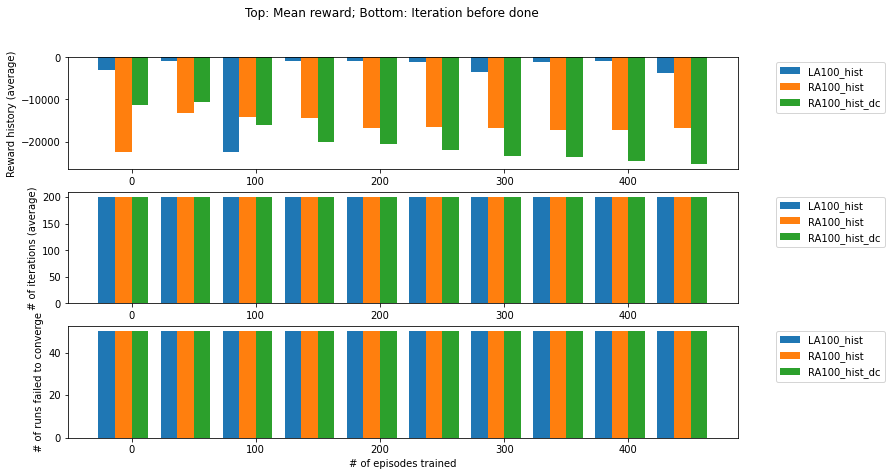

In [10]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA100_hist, RA100_hist, RA100_hist_dc], test_interval, 
                 ['LA100_hist', 'RA100_hist', 'RA100_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [11]:
# If all goes well, save the weights
LA100_ms.save_model('LA100_master_agent_fail')
RA100_ms.save_model('RA100_master_agent_fail')
RA100_ms_dc.save_model('RA100_master_agent_discount_fail')

Saving model to models/LearnerAgent_LA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_discount_fail


In [12]:
# Train the base network (10 agents) for sanity check
N = 10
seed=202020

LA10_ms = LearnerAgent(device, N, env.no, env.na, hidden, action_range=action_space)
RA10_ms = RewardAgent(device, N, env.no, env.na, hidden)
RA10_ms_dc = RewardAgent(device, N, env.no, env.na, hidden)

LA10_hist = train(LA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist = train(RA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist_dc = train(RA10_ms_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

Test result at episode  0 : 
[ 4413704 24652569  2149979 17944302  3496669 27387092 20780609  7059306
  1299038 29624917 13136632 19931242 13668715  6441551  7257224 12174805
 22152455  5732104  4650957 26825903 17460766 12013687 29874228 12685283
 24093321 16027295 18486760 14923213  7426958 24344497  4621167 22685913
  7608716 28200457 28725131 14224184  8158341 12225970  9093556 13240324
  2344491 29980132 17301362 12315336 17510371 25849123 30027574  7672713
  8359724  1224357]
Finished test  0  with  199 ; cumulative reward =  -20109.042803097214
Finished test  1  with  199 ; cumulative reward =  -19224.246357426448
Finished test  2  with  199 ; cumulative reward =  -19303.7421932501
Finished test  3  with  199 ; cumulative reward =  -19443.365887607422
Finished test  4  with  199 ; cumulative reward =  -19145.133043581794
Finished test  5  with  199 ; cumulative reward =  -19310.82393640002
Finished test  6  with  199 ; cumulative reward =  -19344.102159311085
Finished test  7  w

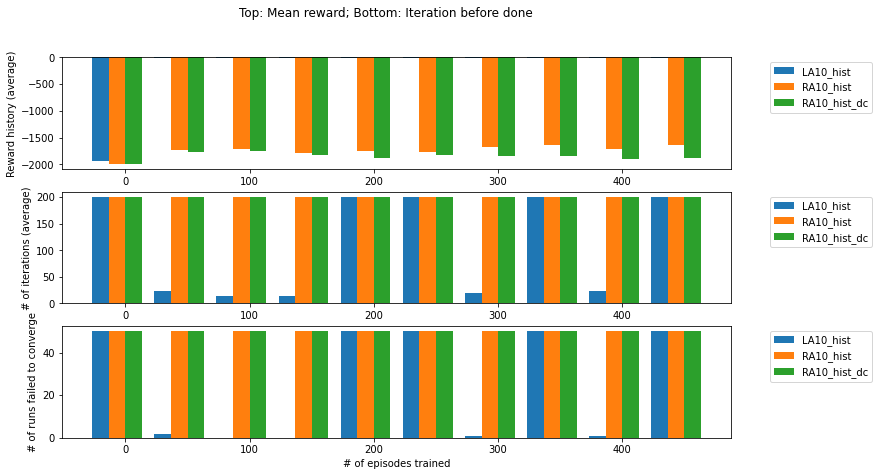

In [13]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA10_hist, RA10_hist, RA10_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

Test result at episode  0 : 
[ 4413704 24652569  2149979 17944302  3496669 27387092 20780609  7059306
  1299038 29624917 13136632 19931242 13668715  6441551  7257224 12174805
 22152455  5732104  4650957 26825903 17460766 12013687 29874228 12685283
 24093321 16027295 18486760 14923213  7426958 24344497  4621167 22685913
  7608716 28200457 28725131 14224184  8158341 12225970  9093556 13240324
  2344491 29980132 17301362 12315336 17510371 25849123 30027574  7672713
  8359724  1224357]
Finished test  0  with  199 ; cumulative reward =  -18314.67238886469
Finished test  1  with  199 ; cumulative reward =  -15498.069110110604
Finished test  2  with  199 ; cumulative reward =  -17522.29508997086
Finished test  3  with  199 ; cumulative reward =  -14354.335237120958
Finished test  4  with  199 ; cumulative reward =  -20326.15683210903
Finished test  5  with  199 ; cumulative reward =  -15413.160380263405
Finished test  6  with  199 ; cumulative reward =  -16871.31990766191
Finished test  7  wi

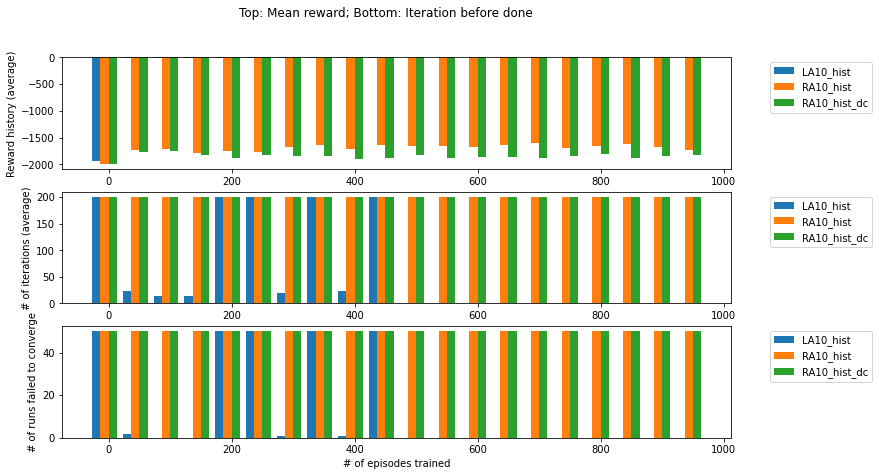

In [14]:
# Additional training
RA10_hist += train(RA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist_dc += train(RA10_ms_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)
plot_reward_hist([LA10_hist, RA10_hist, RA10_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [11]:
# If all goes well, save the weights
LA10_ms.save_model('LA10_master_agent_fail')
RA10_ms.save_model('RA10_master_agent_fail')
RA10_ms_dc.save_model('RA10_master_agent_discount_fail')

Saving model to models/LearnerAgent_LA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_discount_fail


In [50]:
# Bulid environments with different number of agents
env_list = []
N_list = [5, 10, 20, 50, 64]
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped
    )

# Initialize agents for different number of agents and load weights
LApath = 'models/LearnerAgent_test3_LA-uVel-oVel'
RApath = 'models/RewardAgent_test3_RA-uVel-oVel'
prevN = 100
LA_list = []
RA_list = []
for i,N_ in enumerate(N_list):
    LA_list.append(
        LearnerAgent(device, N_, env_list[i].no, env_list[i].na, hidden, prevN=prevN, load_path=LApath)
    )
    RA_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, prevN=prevN, load_path=RApath)
    )

In [51]:
# Train those agents one by one, I guess
LA_hists = []
RA_hists = []
for i,N_ in enumerate(N_list):
    LA_hists.append(
        train(LA_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for LA".format(N_))
    RA_hists.append(
        train(RA_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for RA".format(N_))

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -8506.51639757687
Finished test  1  with  199 ; cumulative reward =  -8334.214023445433
Finished test  2  with  199 ; cumulative reward =  -8249.338408923406
Finished test  3  with  199 ; cumulative reward =  -8064.228116257708
Finished test  4  with  199 ; cumulative reward =  -7867.7625648955345
Finished test  5  with  199 ; cumulative reward =  -7521.297085388528
Finished test  6  with  199 ; cumulative reward =  -7709.240166343952
Finished test  7  with 

In [ ]:
for i,N_ in enumerate(N_list):
    LA_list[i].save_model('tf_test2_N{0}_from_N100'.format(N_))
    RA_list[i].save_model('tf_test2_N{0}_from_N100'.format(N_))

In [52]:
for i,N_ in enumerate(N_list):
    LA_list[i].save_model('tf_test1_N{0}'.format(N_))
    RA_list[i].save_model('tf_test1_N{0}'.format(N_))

Saving model to models/LearnerAgent_tf_test1_N5
Saving model to models/RewardAgent_tf_test1_N5
Saving model to models/LearnerAgent_tf_test1_N20
Saving model to models/RewardAgent_tf_test1_N20
Saving model to models/LearnerAgent_tf_test1_N50
Saving model to models/RewardAgent_tf_test1_N50
Saving model to models/LearnerAgent_tf_test1_N100
Saving model to models/RewardAgent_tf_test1_N100
Saving model to models/LearnerAgent_tf_test1_N250
Saving model to models/RewardAgent_tf_test1_N250


In [60]:
# Test those agents one by one, probably
LA_test_hists = []
RA_test_hists = []
num_test=20
for i,N_ in enumerate(N_list):
    LA_test_hists.append(
        plot_test(LA_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testnig env with {0} agents for LA".format(N_))
    RA_test_hists.append(
        plot_test(RA_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testing env with {0} agents for RA".format(N_))

Finished episode  0  with  199 ;
cumulative reward =  -26.46133640530274
Finished episode  1  with  199 ;
cumulative reward =  -67.7013307807521
Finished episode  2  with  199 ;
cumulative reward =  -22.922306805597483
Finished episode  3  with  199 ;
cumulative reward =  -16.738423134988114
Finished episode  4  with  199 ;
cumulative reward =  -28.495457631416077
Finished episode  5  with  199 ;
cumulative reward =  -10.724129213971148
Finished episode  6  with  199 ;
cumulative reward =  -833.0128039820931
Finished episode  7  with  199 ;
cumulative reward =  -33.5321995311004
Finished episode  8  with  199 ;
cumulative reward =  -23.9644891691149
Finished episode  9  with  199 ;
cumulative reward =  -10.61890931568388
Finished episode  10  with  199 ;
cumulative reward =  -15.64426772372084
Finished episode  11  with  199 ;
cumulative reward =  -18.96526194220137
Finished episode  12  with  199 ;
cumulative reward =  -22.516715465691906
Finished episode  13  with  199 ;
cumulative r

In [175]:
# Compare transferred model weights with source model weights
print("Check LA.fc1")
for j in range(len(LA_list)):
    print(LA_list[j].net.ANlayers[1].weight.data)
print(agent5.net.fc1.weight.data)

print("Check LA.fc2")
for j in range(len(LA_list)):
    print(LA_list[j].net.ANlayers[2].weight.data)
print(agent5.net.fc2.weight.data)

print("Check LA.fc3")
for j in range(len(LA_list)):
    print(LA_list[j].net.ANlayers[3].weight.data)
print(agent5.net.fc3.weight.data)


print("Check RA.fc1")
for j in range(len(RA_list)):
    print(RA_list[j].net.RNlayers[1].weight.data)
print(agent7.net.fc1.weight.data)
print("Check RA.fc2")
for j in range(len(RA_list)):
    print(RA_list[j].net.RNlayers[2].weight.data)
print(agent7.net.fc2.weight.data)
print("Check RA.fc3")
for j in range(len(RA_list)):
    print(RA_list[j].net.RNlayers[3].weight.data)
print(agent7.net.fc3.weight.data)

Check LA.fc1
tensor([[ 0.0994, -0.1567, -0.1747,  ..., -0.2019, -0.2060, -0.0112],
        [-0.1185, -0.1307, -0.5236,  ...,  0.1757, -0.0508,  0.1060],
        [ 0.3451,  0.9522,  0.6599,  ..., -0.0824,  0.2609,  0.3099],
        ...,
        [ 0.2608,  0.0245, -0.0160,  ..., -0.1811, -0.1031, -0.0087],
        [-0.6982, -0.4603, -0.6139,  ..., -0.0215, -0.0372,  0.1413],
        [ 1.0285,  0.6622,  0.4584,  ...,  0.0253, -0.0794, -0.0819]])
tensor([[ 0.0994, -0.1567, -0.1747,  ..., -0.2019, -0.2060, -0.0112],
        [-0.1185, -0.1307, -0.5236,  ...,  0.1757, -0.0508,  0.1060],
        [ 0.3451,  0.9522,  0.6599,  ..., -0.0824,  0.2609,  0.3099],
        ...,
        [ 0.2608,  0.0245, -0.0160,  ..., -0.1811, -0.1031, -0.0087],
        [-0.6982, -0.4603, -0.6139,  ..., -0.0215, -0.0372,  0.1413],
        [ 1.0285,  0.6622,  0.4584,  ...,  0.0253, -0.0794, -0.0819]])
tensor([[ 0.0994, -0.1567, -0.1747,  ..., -0.2019, -0.2060, -0.0112],
        [-0.1185, -0.1307, -0.5236,  ...,  0.1757

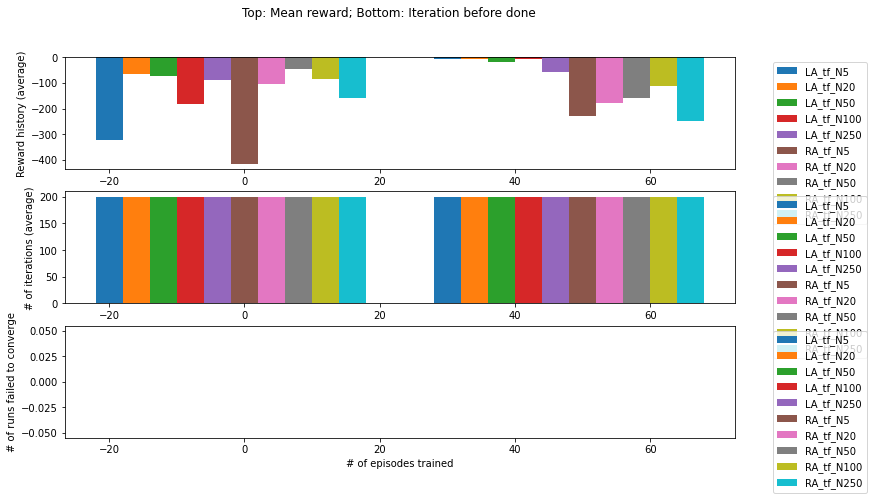

In [69]:
# Plot methods from the previous notebook. I should put it into a util file instead...
# Note that the plot method can now take # of agents into consideration.
# Here I'm squaring N to account for the increased number of possible agent pairs.
plot_reward_hist(LA_hists+RA_hists, test_interval, 
                 ['LA_tf_N{0}'.format(N_) for N_ in N_list] + ['RA_tf_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

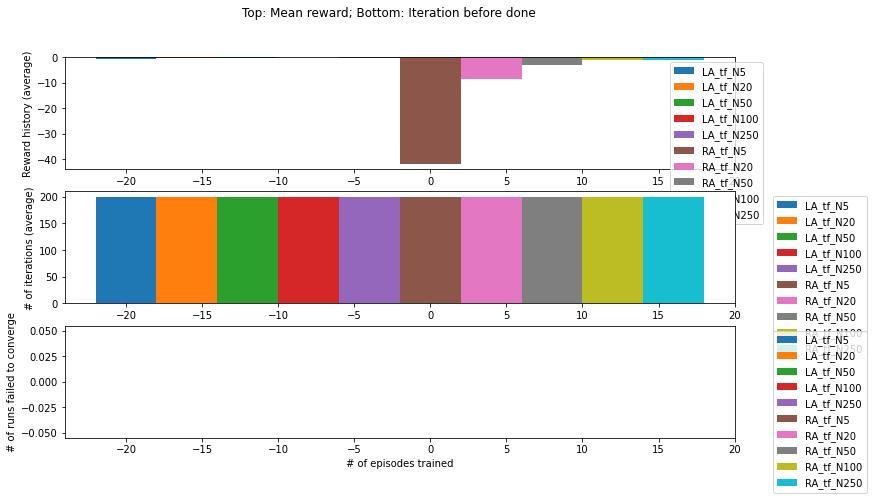

In [68]:
# Plot it for final test runs as well.?
plot_reward_hist([[la] for la in LA_test_hists]+[[ra] for ra in RA_test_hists], test_interval, 
                 ['LA_tf_N{0}'.format(N_) for N_ in N_list] + ['RA_tf_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N*N for N in N_list]*2)

In [70]:
# Now train them from scratch... This will take a while.
na = env.na
ns = env.nf
hidden = 32

num_episode=500
transfer_num_episode=51
test_interval=100
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

if input_type == U_ACCELERATION:
    action_space = [-env.a_max, env.a_max]
else:
    action_space = [-env.v_max, env.v_max]

N_list = [5,20,50,100] # 250 would take too long
LA_scratch_list = []
RA_scratch_list = []
for i,N_ in enumerate(N_list):
    LA_scratch_list.append(
        LearnerAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
    RA_scratch_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )

In [71]:
# Train those agents one by one, I guess
LA_scratch_hists = []
RA_scratch_hists = []
for i,N_ in enumerate(N_list):
    LA_scratch_hists.append(
        train(LA_scratch_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for LA".format(N_))
    RA_scratch_hists.append(
        train(RA_scratch_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for RA".format(N_))

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -9553.033464228954
Finished test  1  with  199 ; cumulative reward =  -9634.662277108138
Finished test  2  with  199 ; cumulative reward =  -9523.974293072992
Finished test  3  with  199 ; cumulative reward =  -9431.704245588511
Finished test  4  with  199 ; cumulative reward =  -9606.614260012655
Finished test  5  with  199 ; cumulative reward =  -9514.59533697434
Finished test  6  with  199 ; cumulative reward =  -9628.346421186467
Finished test  7  with  

In [ ]:
# You'll have to do additional trainings here, guaranteed...
num_episode = 500
additional_train_LA = [False, False, True, True, True]
additional_train_RA = [False, False, True, True, True]
for i,N_ in enumerate(N_list):
    if additional_train_LA[i]:
        LA_scratch_hists[i] += train(LA_scratch_list[i], env_list[i], 
                  num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
        print("Finished training env with {0} agents for LA".format(N_))
    if additional_train_RA[i]:
        RA_scratch_hists[i] += train(RA_scratch_list[i], env_list[i], 
                  num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
        print("Finished training env with {0} agents for RA".format(N_))

In [72]:
for i,N_ in enumerate(N_list):
    LA_scratch_list[i].save_model('fs_test1_N{0}'.format(N_))
    RA_scratch_list[i].save_model('fs_test1_N{0}'.format(N_))

Saving model to models/LearnerAgent_fs_test1_N5
Saving model to models/RewardAgent_fs_test1_N5
Saving model to models/LearnerAgent_fs_test1_N20
Saving model to models/RewardAgent_fs_test1_N20
Saving model to models/LearnerAgent_fs_test1_N50
Saving model to models/RewardAgent_fs_test1_N50
Saving model to models/LearnerAgent_fs_test1_N100
Saving model to models/RewardAgent_fs_test1_N100


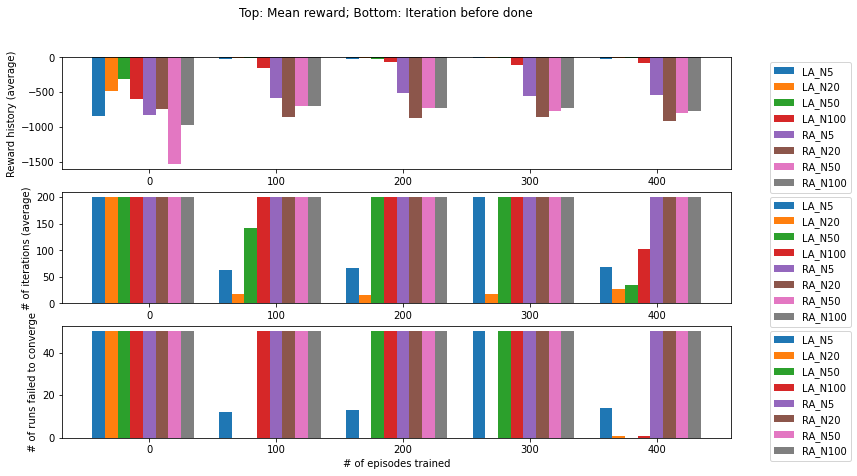

In [78]:
plot_reward_hist(LA_scratch_hists+RA_scratch_hists, test_interval, 
                 ['LA_N{0}'.format(N_) for N_ in N_list] + ['RA_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

In [74]:
# Test those agents one by one, probably
LA_scratch_test_hists = []
RA_scratch_test_hists = []
for i,N_ in enumerate(N_list):
    LA_scratch_test_hists.append(
        plot_test(LA_scratch_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testnig env with {0} agents for LA".format(N_))
    RA_scratch_test_hists.append(
        plot_test(RA_scratch_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testing env with {0} agents for RA".format(N_))

Took  16  steps to converge
Finished episode  0  with  16 ;
cumulative reward =  -15.764018696585339
Took  22  steps to converge
Finished episode  1  with  22 ;
cumulative reward =  -50.48165512886289
Finished episode  2  with  199 ;
cumulative reward =  -1261.5127308858016
Took  18  steps to converge
Finished episode  3  with  18 ;
cumulative reward =  -39.70760907333687
Finished episode  4  with  199 ;
cumulative reward =  -1429.2046834537439
Took  15  steps to converge
Finished episode  5  with  15 ;
cumulative reward =  -20.355787478436206
Finished episode  6  with  199 ;
cumulative reward =  -1627.3208992991592
Finished episode  7  with  199 ;
cumulative reward =  -764.3719323233386
Finished episode  8  with  199 ;
cumulative reward =  -1019.3615986308794
Took  16  steps to converge
Finished episode  9  with  16 ;
cumulative reward =  -16.548758096602914
Took  15  steps to converge
Finished episode  10  with  15 ;
cumulative reward =  -18.65467203553503
Finished episode  11  with 

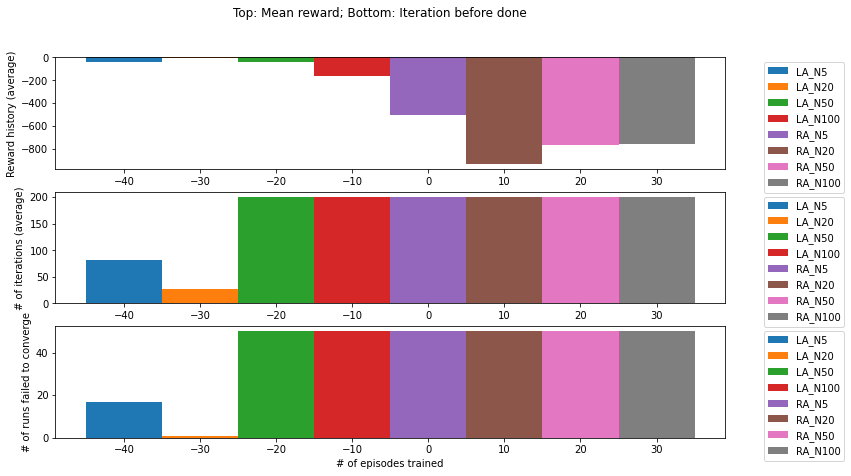

In [79]:
plot_reward_hist([[l] for l in LA_scratch_test_hists] + [[r] for r in RA_scratch_test_hists], test_interval, 
                 ['LA_N{0}'.format(N_) for N_ in N_list] + ['RA_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

## Try out Actor-Critic

In [90]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *

num_episode=250
test_interval=50
num_test=25
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

N_list = [5,20,50,100] # 250 would take too long
AC1_list = []
for i,N_ in enumerate(N_list):
    AC1_list.append(
        AC1Agent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
AC1_hist = []
for i,N_ in enumerate(N_list):
    AC1_hist.append(
        train(AC1_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
AC1_test_hist = []
for i,N_ in enumerate(N_list):
    AC1_test_hist.append(
        plot_test(AC1_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testnig env with {0} agents for AC".format(N_))

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054]
Finished test  0  with  199 ; cumulative reward =  -3998.5114140240375
Finished test  1  with  199 ; cumulative reward =  -4739.567302325716
Finished test  2  with  199 ; cumulative reward =  -4642.966453515883
Finished test  3  with  199 ; cumulative reward =  -4111.3603366655425
Finished test  4  with  199 ; cumulative reward =  -5039.489032525821
Finished test  5  with  199 ; cumulative reward =  -3187.081293405305
Finished test  6  with  199 ; cumulative reward =  -3513.795009187124
Finished test  7  with  199 ; cumulative reward =  -4185.428094165022
Finished test  8  with  199 ; cumulative reward =  -2578.767811588622
Finished test  9  with  199 ; cumulative reward =  -3338.019505993276
Finished test  10  with  199 ; cumulati

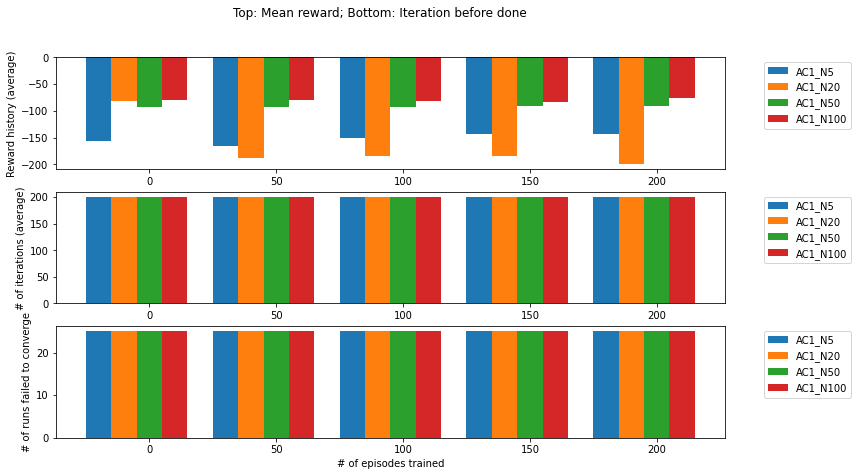

In [91]:
plot_reward_hist(AC1_hist, test_interval, 
                 ['AC1_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

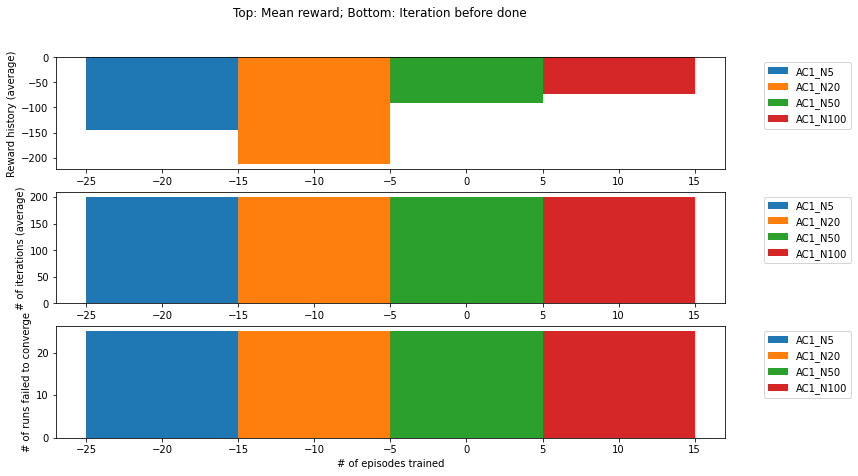

In [92]:
plot_reward_hist([[l] for l in AC1_test_hist], test_interval, ['AC1_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

In [147]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=500
test_interval=50
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

N_list = [5,20,50,100] # 250 would take too long
AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
AC2_list.append(
    AC2Agent(device, 10, env.no, env.na, hidden)
)

AC2_hist = []
for i,N_ in enumerate(N_list):
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
AC2_hist.append(
    train(AC2_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )

AC2_test_hist = []
for i,N_ in enumerate(N_list):
    AC2_test_hist.append(
        plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
AC2_test_hist.append(
    plot_test(AC2_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
)

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -9468.117948340443
Finished test  1  with  199 ; cumulative reward =  -9523.64866001604
Finished test  2  with  199 ; cumulative reward =  -9534.413258330813
Finished test  3  with  199 ; cumulative reward =  -9650.511852946762
Finished test  4  with  199 ; cumulative reward =  -9563.617946287413
Finished test  5  with  199 ; cumulative reward =  -9608.695923825526
Finished test  6  with  199 ; cumulative reward =  -9689.252568348304
Finished test  7  with  

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x13c9639e8>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 81, in close
    if self.isopen and sys.meta_path:
AttributeError: 'Viewer' object has no attribute 'isopen'


Test result at episode  50 : 
[ 7390154 24015534 17990003 14888813 18607934  2171963 27415570 27854806
  1808082 22485693 30540709 21194943 17148885 21570314 15290485 17369304
  9020937 19794313 21708174  2181374  1202653 20365815 18203127  5411736
 25137971 29836360  7818647 17300465  5015849  8394556 16091008  9715322
 22078028  4543761  8354700 23203881  9696195  8856666 13356874 15522854
 19703616 15454833 23037277 11461011 30886902 21480815 11994712  1854044
 25341078 26686162]
Finished test  0  with  199 ; cumulative reward =  -42467.65309206503
Finished test  1  with  199 ; cumulative reward =  -41278.16988363921
Finished test  2  with  199 ; cumulative reward =  -42200.24207555486
Finished test  3  with  199 ; cumulative reward =  -40662.74158942186
Finished test  4  with  199 ; cumulative reward =  -40910.3245048982
Finished test  5  with  199 ; cumulative reward =  -42158.78993322247
Finished test  6  with  199 ; cumulative reward =  -40766.830940633394
Finished test  7  with

RuntimeError: shape '[1, -1, 100]' is invalid for input of size 40

In [148]:

AC2_list.append(
    AC2Agent(device, 10, env.no, env.na, hidden)
)
AC2_hist.append(
    train(AC2_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )

AC2_test_hist = []
for i,N_ in enumerate(N_list):
    AC2_test_hist.append(
        plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
AC2_test_hist.append(
    plot_test(AC2_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
)

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -19366.41760636126
Finished test  1  with  199 ; cumulative reward =  -19702.359712801204
Finished test  2  with  199 ; cumulative reward =  -19255.301098675674
Finished test  3  with  199 ; cumulative reward =  -19407.06504419061
Finished test  4  with  199 ; cumulative reward =  -19666.36647291335
Finished test  5  with  199 ; cumulative reward =  -19319.980644114938
Finished test  6  with  199 ; cumulative reward =  -19684.669430858765
Finished test  7  w

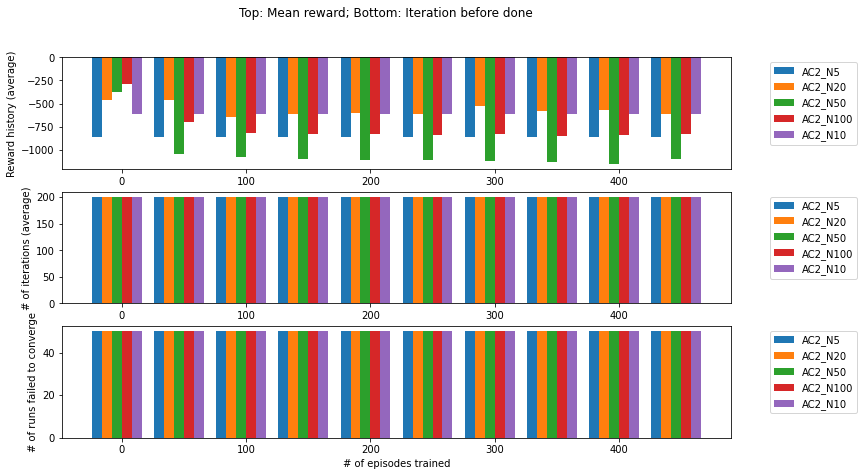

In [155]:
plot_reward_hist(AC2_hist, test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list]+['AC2_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([np.sqrt(N) for N in N_list]+[np.sqrt(10)])*2)

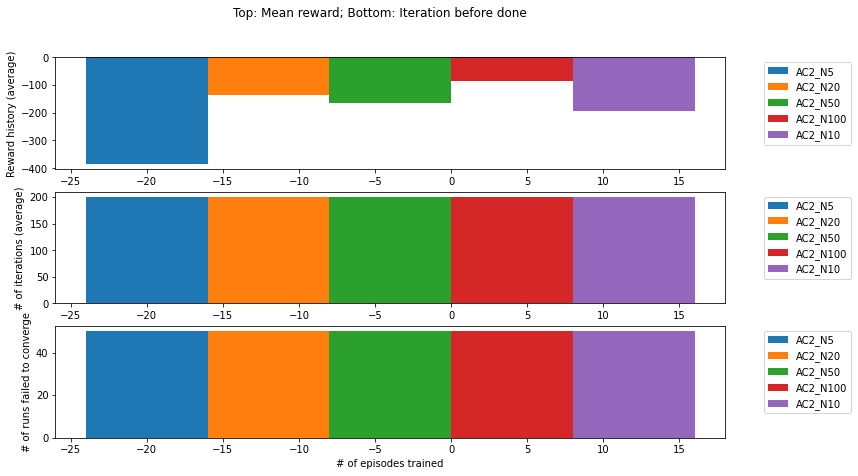

In [150]:
plot_reward_hist([[l] for l in AC2_test_hist], test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list]+['AC2_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [134]:
reload(utils.agents)
from utils.agents import *

num_episode=500
test_interval=50
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

# Do DDPG
DDPG_list = []
for i,N_ in enumerate(N_list):
    DDPG_list.append(
        DDPGAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
DDPG_list.append(
    DDPGAgent(device, 10, env.no, env.na, hidden)
)

DDPG_hist = []
for i,N_ in enumerate(N_list):
    DDPG_hist.append(
        train(DDPG_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
DDPG_hist.append(
    train(DDPG_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
)
    
DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -9529.033302757009
Finished test  1  with  199 ; cumulative reward =  -9561.841186772077
Finished test  2  with  199 ; cumulative reward =  -9525.799984433535
Finished test  3  with  199 ; cumulative reward =  -9669.54884181276
Finished test  4  with  199 ; cumulative reward =  -9605.932974288547
Finished test  5  with  199 ; cumulative reward =  -9619.159543119904
Finished test  6  with  199 ; cumulative reward =  -9746.762138456907
Finished test  7  with  

RuntimeError: shape '[1, -1, 100]' is invalid for input of size 40

In [137]:

DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

Finished episode  0  with  199 ;
cumulative reward =  -9837.671626131085
Finished episode  1  with  199 ;
cumulative reward =  -10391.991220207801
Finished episode  2  with  199 ;
cumulative reward =  -9945.994149509303
Finished episode  3  with  199 ;
cumulative reward =  -10170.38445060866
Finished episode  4  with  199 ;
cumulative reward =  -10225.054628529968
Finished episode  5  with  199 ;
cumulative reward =  -9405.984521719145
Finished episode  6  with  199 ;
cumulative reward =  -10072.129719639854
Finished episode  7  with  199 ;
cumulative reward =  -10441.678299420599
Finished episode  8  with  199 ;
cumulative reward =  -10411.612683652058
Finished episode  9  with  199 ;
cumulative reward =  -10032.283517569784
Finished episode  10  with  199 ;
cumulative reward =  -9586.257039199816
Finished episode  11  with  199 ;
cumulative reward =  -9892.78461986566
Finished episode  12  with  199 ;
cumulative reward =  -10123.28956565129
Finished episode  13  with  199 ;
cumulativ

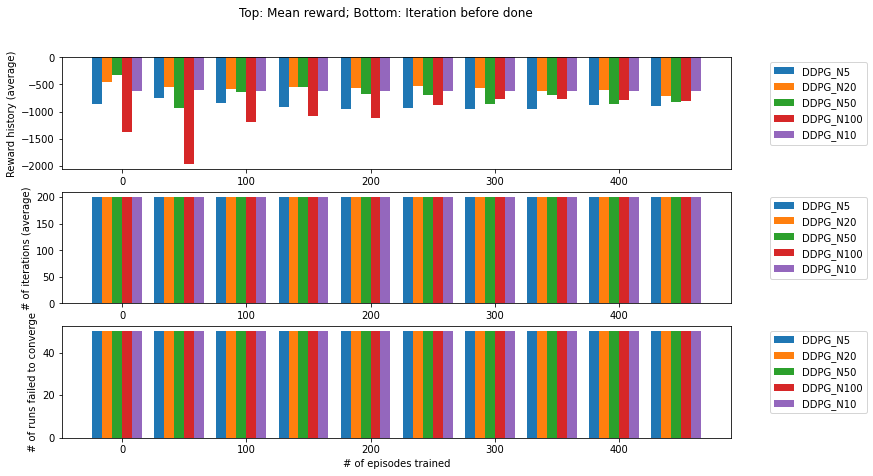

In [154]:
plot_reward_hist(DDPG_hist, test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([np.sqrt(N) for N in N_list]+[np.sqrt(10)])*2)

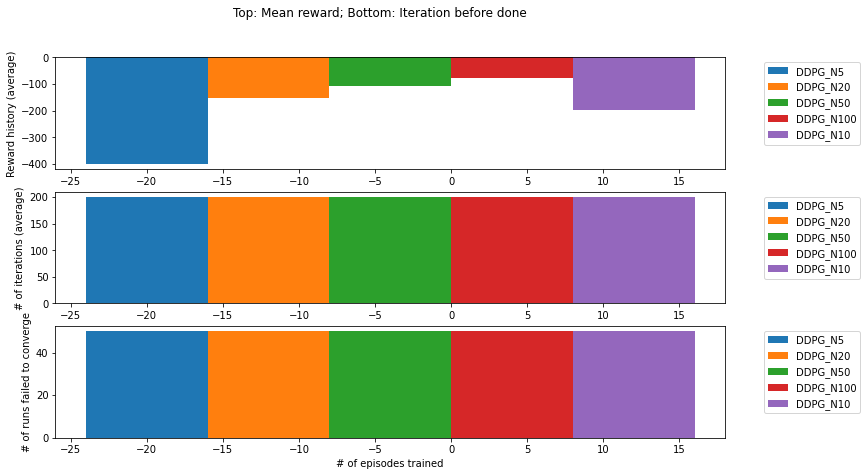

In [140]:
plot_reward_hist([[l] for l in DDPG_test_hist], test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [151]:

def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(AC2_list[i],'AC2_test2_N{0}'.format(N_))
    
def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    torch.save(agent.netAT.state_dict(), agent_path+"_AT")
    torch.save(agent.netCT.state_dict(), agent_path+"_CT")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(DDPG_list[i],'DDPG_test2_N{0}'.format(N_))

Saving model to models/AC2Agent_AC2_test2_N5
Saving model to models/AC2Agent_AC2_test2_N20
Saving model to models/AC2Agent_AC2_test2_N50
Saving model to models/AC2Agent_AC2_test2_N100
Saving model to models/AC2Agent_AC2_test2_N10
Saving model to models/DDPGAgent_DDPG_test2_N5
Saving model to models/DDPGAgent_DDPG_test2_N20
Saving model to models/DDPGAgent_DDPG_test2_N50
Saving model to models/DDPGAgent_DDPG_test2_N100
Saving model to models/DDPGAgent_DDPG_test2_N10


### Play around with the gradient agent

In [81]:
# Play around with the gradient agent
N = 10
GA = GradientAgent(device, 10, ns, hidden)
GA.load_model('models/GradientAgent_test3_GA')

Loading model from models/GradientAgent_test3_GA


In [168]:
# Test model
class GradientAgentTest(BaseAgent):
    def __init__(self, device, N, ns=2, hidden=24, action_range=[-1,1], learning_rate=0.01, centralized=False):
        super().__init__(device, N)
        self.centralized = centralized
        if centralized:
            pass
        else:
            self.net = EnergyNet(N, 2, hidden)
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=learning_rate)
        self.needsExpert = True
        self.name = 'GradientAgentTest'
        self.range = action_range[1] - action_range[0]
        self.offset = 0.5*(action_range[0]+action_range[1])
        self.na = 2
    
    def getNextState(self, observed_state, action, dt=0.01):
        # Input: observed_state is a (M,2+,N) array, and action is (M,2). Each agent corresponds to a row.
        # Output: Supposedly, a (M,2,N) array that contains the expected new observed state.
        # Right now we're manually giving the agent a sense of its own dynamics with velocity input (single integrator)...
        # Hopefully it could go automatically soon.
        # Limitation: Doens't know if 0 means "not observed" or "already together". By default we assume the first. 
        # Thus, we first get a M*N matrix that records the neighbor information
        M,_,N = observed_state.shape
        is_neighbor = np.zeros((M,N))
        is_neighbor[ (observed_state[:,0,:]!=0) & (observed_state[:,1,:]!=0) ] = 1
        # Next, find the new relative distances based on the action. Assuming action means velocity, and we use a small dt.
        new_dists = observed_state[:,:2,:] - dt * action.reshape(M,2,1) # Broadcast action (M,2) to (M,2,N)
        # Filter out unobserved states
        new_dists *= is_neighbor.reshape(M,1,N)
        return new_dists
    
    def getEnergy(self, observed_state):
        # This is the expert that finds the energy function for each agent, but shhh don't let the rest know
        # Input: observed_state, expecting shape to be (N,no,N), as per the current environment, and be full of distance norms
        # Output: Probably (N,1), one for each agent. Let's make it only dependent on position for now; use velocity later.
        sum_dists = np.sum(np.linalg.norm(observed_state[:,:2,:], ord=2, axis=1), axis=1)
        print("Energy function says: ", sum_dists)
        return sum_dists
    
    # Picks an action based on given state.
    def select_action(self, state, **kwargs):
        # Input shape: state has shape (ns,N)
        with torch.no_grad():
            # Find gradients in both action space directions
            dt = 0.01
            da = 0.1
            sample_ax1p = self.getNextState(state.view(1,-1,self.N).detach().numpy(), np.array([[da,0]]).astype('float32'), dt) # Now shape: (1,2,N)
            sample_ax1n = self.getNextState(state.view(1,-1,self.N).detach().numpy(), np.array([[-da,0]]).astype('float32'), dt)
            sample_ax1p = self.net(torch.from_numpy(sample_ax1p)).squeeze().detach().numpy()
            sample_ax1n = self.net(torch.from_numpy(sample_ax1n)).squeeze().detach().numpy()
            sample_ax2p = self.net(
                torch.from_numpy(self.getNextState(state.view(1,-1,self.N).detach().numpy(), 
                                np.array([[0,da]]).astype('float32'), dt))).squeeze().detach().numpy()
            sample_ax2n = self.net(
                torch.from_numpy(self.getNextState(state.view(1,-1,self.N).detach().numpy(), 
                                np.array([[0,-da]]).astype('float32'), dt))).squeeze().detach().numpy()
            print("Action-induced values in each direction: \n", sample_ax1p,sample_ax1n, sample_ax2p,sample_ax2n)
            # Calculate approximate gradient
            action_dir = np.array([(sample_ax1p-sample_ax1n), (sample_ax2p-sample_ax2n)])*2/da/dt
#             print(action_dir)
            return np.clip(action_dir, -1,1)
    
    # Steps over gradients from memory replay
    def optimize_model(self, batch, **kwargs):
        B = kwargs.get('B', len(batch))
        # This class would assume that the optimal action is stored in batch input
        state_batch = torch.cat(batch.state)
        
        # Find loss & optimize the model
        self.net.train() 
        pred_energy = self.net(state_batch.view(B, -1, self.N)[:,:2,:]).squeeze() # Input shape should be (B,no,N) and output be (B,1)
        energy = torch.from_numpy(self.getEnergy(state_batch.view(B, -1, self.N).detach().numpy()))
        print("Actual energy = ", energy, " vs predicted energy = ", pred_energy)

        self.optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(energy, pred_energy)
        print(loss)
        loss.backward()
        self.optimizer.step()


In [169]:
def train_gradient(agent, env, num_episode=50, test_interval=25, num_test=20, num_iteration=200, 
          BATCH_SIZE=128, num_sample=50, action_space=[-1,1], debug=True, memory=None, seed=2020,
          update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_NO, gamma=0.99):
    test_hists = []
    steps = 0
    if memory is None:
        memory = ReplayMemory(1000 * env.N)
    
    # Values that would be useful
    N = env.N
    # Note that the seed only controls the numpy random, which affects the environment.
    # To affect pytorch, refer to further documentations: https://github.com/pytorch/pytorch/issues/7068
    np.random.seed(seed)
    test_seeds = np.random.randint(0, 5392644, size=(num_episode // test_interval)+1)

    for e in range(num_episode):
        steps = 0
        state = env.reset()
        state = torch.from_numpy(state).float()
        state = Variable(state)

        # Train History
        state_pool = []
        action_pool = []
        reward_pool = []
        next_state_pool = []

        for t in range(num_iteration):
            # agent.net.train()
            agent.set_train(True)
            # Try to pick an action, react, and store the resulting behavior in the pool here
            actions = []
            for i in range(N):
                action = agent.select_action(state[i], **{
                    'steps_done':t, 'num_sample':50, 'action_space':action_space
                })
                actions.append(action)
            action = np.array(actions).T # Shape would become (2,N)
            print("Agent's choice: ", action)

            next_state, reward, done, _ = env.step(action)
            print("After taking action ", action, " at state ", state, " with shape ", state.shape, ": ")
            print("True next state: ", next_state, "\n with shape = ", next_state.shape)
            print("Predicted next state: ", agent.getNextState(
                state.detach().numpy(), action, env.dt
            ))
            next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
            action = action.T # Turn shape back to (N,2)

            if agent.needsExpert:
                # If we need to use expert input during training, then we consult it and get the best action for this state
                actions = env.controller()
                action = actions.T # Shape should already be (2,N), so we turn it into (N,2)
                print("In comparison, environment best action: ", action)
            
            if reward_mode == FUTURE_REWARD_NO:
                # Push everything directly inside if we don't use future discounts
                for i in range(N):
                    memory.push(state[i], action[i], next_state[i], reward[i])
            else:
                # Store and push them outside the loop
                state_pool.append(state)
                action_pool.append(action)
                reward_pool.append(reward)
                next_state_pool.append(next_state)
            
            state = next_state
            steps += 1
            
            if done:
                print("Took ", t, " steps to converge")
                break
        
        if reward_mode == FUTURE_REWARD_YES:
            for j in range(len(reward)):
                if j > 0:
                    reward_pool[-j-1] += gamma * reward_pool[-j]
                for i in range(N):
                    memory.push(state_pool[-j-1][i], action_pool[-j-1][i], 
                                next_state_pool[-j-1][i], reward_pool[-j-1][i])
                
        # Update 1028: Moved this training step outside the loop
        if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            agent.optimize_model(batch, **{'B':BATCH_SIZE})
            
        if e % test_interval == 0:
            print("Test result at episode ", e, ": ")
            test_hist = test(agent, env, num_test, num_iteration, num_sample, action_space, 
                             seed=test_seeds[int(e/test_interval)], debug=debug)
            test_hists.append(test_hist)
    env.close()
    return test_hists

In [170]:
# Run for one step and check the intermediate values
gat = GradientAgentTest(device, 10, env.no, hidden=32, action_range=[-1,1], learning_rate=0.01, centralized=False)
gat.load_model('models/GradientAgent_test3_GA')

Loading model from models/GradientAgent_test3_GA


In [171]:
train_gradient(gat, env, num_episode=5, test_interval=25, num_test=2, num_iteration=5, seed=2020)

Action-induced values in each direction:  -0.00025314093 -0.00012302399
Action-induced values in each direction:  -0.00016826391 -0.00025177002
Action-induced values in each direction:  -0.000623405 -0.00040477514
Action-induced values in each direction:  -0.00041168928 -0.00023698807
Action-induced values in each direction:  -0.00016957521 -0.00059759617
Action-induced values in each direction:  -0.0004515648 -0.0002681017
Action-induced values in each direction:  -0.00032031536 -0.0005813837
Action-induced values in each direction:  -0.000113904476 -0.0007010102
Action-induced values in each direction:  -0.0005123615 -5.465746e-05
Action-induced values in each direction:  -7.688999e-05 -0.00043213367
Agent's choice:  [[-0.50628185 -0.33652782 -1.         -0.82337856 -0.33915043 -0.9031296
  -0.6406307  -0.22780895 -1.         -0.15377998]
 [-0.24604797 -0.50354004 -0.8095503  -0.47397614 -1.         -0.5362034
  -1.         -1.         -0.10931492 -0.86426735]]
After taking action  [

IndexError: list index out of range

In [23]:
# Scratch work for checking transfer learning implementations
# class ActionNetTF(nn.Module):
#     def __init__(self, N, prevN, ns=2, na=5, hidden=24, action_range=[-1,1]):
#         super(ActionNetTF, self).__init__()
#         self.N = N # Number of agents
#         self.range = action_range[1] - action_range[0]
#         self.offset = 0.5*(action_range[0]+action_range[1])

#         self.flt = nn.Flatten() # Turns 2D input observation into 1D, so we can use linear layers
#         self.fc1 = nn.Linear(ns*prevN, hidden) # Take in flattened input
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, na)

#     def forward(self, x):
#         x = self.flt(x)
#         x = torch.tanh(self.fc1(x))
#         x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x)) # Range = [-1,1]
#         return x * self.range * 0.5 + self.offset

# testacttf = ActionNetTF(N=23, prevN=10, ns=4, na=2, hidden=32)
# testacttf.load_state_dict(torch.load('models/LearnerAgent_test3_LA-uVel-oVel'))
# testacttf.flt = nn.Sequential(testacttf.flt, nn.Linear(2*23, 20))#torch.numel()))

In [32]:
class ActionNetTF(nn.Module):
    def __init__(self, N, prevN, path, ns=2, na=5, hidden=24, action_range=[-1,1]):
        super(ActionNetTF, self).__init__()
        self.N = N # Number of agents
        self.range = action_range[1] - action_range[0]
        self.offset = 0.5*(action_range[0]+action_range[1])

        self.flt = nn.Flatten() # Turns 2D input observation into 1D, so we can use linear layers
        self.fc1 = nn.Linear(ns*prevN, hidden) # Take in flattened input
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, na)
        
        self.load_state_dict(torch.load(path))
        self.fc1 = nn.Sequential(nn.Linear(ns*N, ns*prevN), self.fc1)

    def forward(self, x):
        x = self.flt(x)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x)) # Range = [-1,1]
        return x * self.range * 0.5 + self.offset

testacttf = ActionNetTF(N=23, prevN=10, path='models/LearnerAgent_test3_LA-uVel-oVel', ns=4, na=2, hidden=32)
# Test with a probing input
testacttf(torch.from_numpy(np.ones((1,4,23)).astype('float32')))

tensor([[0.0064, 0.2938]], grad_fn=<AddBackward0>)